# 1. Markov Chain Monte Carlo

## 1.1. Challenges in Bayesian inference

In the previous session we saw a sample of distances to stars from a volume-limited survey, and a model describing their distribution. We constructed the posterior of the model parameter $\alpha$ (power law index) and by maximizing it we estimate the value of $\alpha$.

Our approach was simple because the model had just one parameter. Also, we didn't go on estimating the uncertainty on $\alpha$.

In this session we will see a general method of that can be applied to simple and complex model fits, able to provide the uncertainty of the fitted values.

#### Challenge 1: multiple parameters $\equiv$ multiple dimensions

If our model has many parameters, $\theta_1, \theta_2, \cdots, \theta_k$, then the posterior is a $k$-dimensional function.

$$ P(\theta_1, \theta_2, \cdots, \theta_k | \mathrm{Data}) $$

Finding the maximum in a $k$-D function is even harder than in the $1$-D case. 

We could try to compute the posterior in a $k$-dimensional **grid** and select the point with the highest posterior. Though, a complex function might have narrow peaks so a high resolution in the grid might be necessary. The higher the resolution and the number of dimensions, the higher number of evaluations of the posterior - making the computation extremely time consuming.

#### Challenge 2: uncertainties

Maximizing the posterior provides an estimate of the parameter but not its uncertainty. There are approximate solutions to get an estimate of the uncertainty of the parameter, but they usually make an assumption about the shape of the posterior (e.g. Gaussian peak). Again, evaluating the posterior for a grid can be used, but as we discussed above, this approach is compuationally expensive.

#### Brute-force is even worse...
Another complication with grids is that we may spend a lot of time at regions of the parameter space where the posterior is low. Instead, we would like to spend more time around the peaks, the regions of high posterior probability.

<figure>
 <img src="images/testfunc.png" alt="From [1]" />
 <figcaption>
 <center>Mishra's Bird function. From [1].</center>
 </figcaption>
</figure>


## 1.2. A solution through sampling

**If we could sample** from the posterior distribution $N$ points from the $n$-dimensional parameter space

$$ \Theta_1 \equiv \left(\theta_{1,1}, \theta_{2,1}, \cdots, \theta_{k,1}\right) $$
$$ \Theta_2 \equiv \left(\theta_{1,2}, \theta_{2,2}, \cdots, \theta_{k,2}\right) $$
$$ \vdots $$
$$ \Theta_N \equiv \left(\theta_{1,N}, \theta_{2,N}, \cdots, \theta_{k,N}\right) $$

then the expected value of each parameter $\theta_i$ could be estimated by computing:

$$ \bar{\theta}_i = \frac{1}{N} \sum\limits_{j=1}^{N} { \theta_{i,j} } $$

In a similar way, the uncertainty is given by the formula for the sample standard deviation:

$$ \sigma_{\theta_i} = \sqrt { \frac{1}{N-1}\sum\limits_{j=1}^{N}{ \left(\theta_{i,j} - \bar{\theta}_i  \right)^2 } }$$

Almost all statistical quantities that we may need (covariances, medians, etc) can be computed using a large sample from the posterior. The bigger the sample, the better accuracy in our estimates.


## 2. Markov Chain Monte Carlo method

The Marcov Chain Monte Carlo is a widely used technique to sample from probability distributions (not just posteriors.)

It is based on the idea of creating a chain of points of the parameter space, using a combination of (i) random walk and (ii) selection of points based on their relative probability.

An algorithm is used to ensure that the chain will reach **equilibrium**: after a number of steps (or legnth of the Markov chain) the chain will contain points that follow the same distribution, the **target distribution**.

> It is often characterized as one of the most influencial algorithms of the 20th century...

### 2.1. Metropolis-Hastings algorithm for the distance example

We will discuss the Metropolis-Hastings algorithm, but note that there are *many* others out there. Here are the steps:

1. We start with one set of parameters $\theta_1$. 

    - In our case, $\theta_1$ is simply $\alpha$ since we have only one parameter in our model.
    
    - In general, $\theta_1$ can be a vector of 1, 5, or even a million separate parameters.
    
    This first value starts our Markov chain.
      
2. Using some method we obtain a new trial set of parameters $\theta_2$. *A proposition for a new position...*
    
    - It is important that this set is chosen randomly, but based on the previous set.
    - The dependence on only the previous set, is an essential property of a *Markov chain*.
    - The randomness is where the *Monte Carlo* in MCMC comes from.
    - The simplest method to obtain our new parameter values will be to add some random (Gaussian?) noise to our current value: $\theta_2 = \theta_1 + \epsilon$. This is also called **step size**. You typically want to tune the step size, $\epsilon$, to optimize the process.

3. Now, we want to calculate and compare the posterior probabilities for both $\theta_1$ and $\theta_2$. If the new parameter is better than the current one,

    $$ P(\theta_2) > P(\theta_1) $$
    we always move the chain to $\theta_2$. If not, we *might* move to $\theta_2$ with probability equal to the ratio
    $$ \frac{P(\theta_2)}{P(\theta_1)}$$
    In practice, we draw a random number from a uniform distribution between 0 and 1. If that random number is less than the ratio, we move the chain to $\theta_2$. Else, we stay at $\theta_1$ for another iteration.

4. Now that we have our new value for $\theta$, we return to step 2 and repeat for as many iterations as we want. Often this is in the thousands or more.

<figure>
 <img src="images/mh.png" alt="From [1]" />
 <figcaption>
 <center>Metropolis-Hastings algorithm creating a Markov Chain. From [2].</center>
 </figcaption>
</figure>

### 2.3. Let's code it up...

In [ ]:
def metro_hastings(ln_posterior, theta_0, N_steps, step_size=0.2, args=[]):
    """Metropolis-Hastings algorith for sampling the posterior distribution.

    Parameters
    ----------
    ln_posterior : function that returns the logarithm of the posterior
    theta_0      : initial guess for the model parameter
    N_steps      : the length of the Markov Chain that will be returned
    step_size    : the standard deviation of the normally distributed step size
    args         : additional arguments to be passed to the posterior function
    
    Returns
    -------
    A numpy array containing the Markov Chain.
    
    """
    
    chain = np.zeros(N_steps)                     # create the chain
    chain[0] = theta_0                            # store the initial point...
    print("{:.3f}".format(chain[0]), end=",")     # ...and print it!
    
    # hold the current value of the posterior to avoid recomputing it if position is not changed
    curr_P = ln_posterior(theta_0, *args)
    
    for i in range(N_steps - 1):
        new_theta = chain[i] + np.random.normal(scale=step_size)
        new_P = ln_posterior(new_theta, *args)
        
        # should we move to the new position?
        if (new_P > curr_P) or (np.random.rand() < np.exp(new_P - curr_P)):
            # if yes... store the new value, print it and update the 'current posterior'
            chain[i + 1] = new_theta
            print("{:.3f}".format(chain[i + 1]), end=",")
            curr_P = new_P
        else:
            # if no... store again the current position and print a '.'
            chain[i + 1] = chain[i]
            print(".", end=", ")
            
    return chain

### 2.3. Applying the algorithm on data
Now, let's create the data like we did in the previous section, for 100 stars and run the algorithm for 200 steps.

In [ ]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import time

# Let's make the data for the distance example
N_stars=500
dist_max = 1.0 # in kpc
dist = np.random.uniform(size=N_stars)**(1.0/3.0) * dist_max
dist_err = 0.1 * np.ones(len(dist))
dist_obs = dist + np.random.normal(size=N_stars, scale=dist_err)

# Let's define the posterior function

def func_pdf(alpha, x_max, x):
    P_x = (alpha + 1.0) * x ** alpha / x_max ** (alpha + 1.0)
    
    if isinstance(x, np.ndarray):
        P_x[x > x_max] = 0.0 
        P_x[x < 0.0] = 0.0
    elif (x > x_max) or (x < 0.0):
        return 0.0
    
    return P_x

def ln_prior(alpha):
    if alpha <= 0.0:
        return -np.inf
    return 0.0

def ln_likelihood(alpha, x_max, x_obs, x_err):
    result = 0.0
    for i in range(len(x_obs)):
        a, b = (0.0 - x_obs[i]) / x_err[i], (x_max - x_obs[i]) / x_err[i]
        ran_x = st.truncnorm.rvs(a, b, loc=x_obs[i], scale=x_err[i], size=400)
        ran_y = func_pdf(alpha, x_max, ran_x)
        result += np.log(np.mean(ran_y))
    return result

def ln_posterior(alpha, x_max, x_obs, x_err):
    return ln_prior(alpha) + ln_likelihood(alpha, x_max, x_obs, x_err)

In [ ]:
start = time.time()

alpha_0 = 3.0
chain = metro_hastings(ln_posterior, alpha_0, args=(dist_max, dist_obs, dist_err), N_steps=200)

end = time.time()
print()
print("Elapsed time:", end-start, "seconds")

### The produced Markov Chain and the burn in

The first steps in the chain are not in the optimal regime. This is called the "burn-in" and is thrown away. In principle, there is no absolute way to determine if your chains have converged to the optimal region of parameter space. In practice, unless your problem is pathological, it is usually pretty obvious. Do remember this can be an issue and take care!

In [ ]:
n_burnin = 30   # change this value if needed

plt.figure()
plt.axvspan(0, n_burnin, color="k", alpha=0.3)
plt.plot(chain)
_, _, y_min, y_max = plt.axis()
plt.text(n_burnin + 3, (y_min + y_max) / 2.0, "Burn-in")
chain_converged = chain[n_burnin:]
plt.xlim(0,len(chain))
plt.show()

### Acceptance fraction

The acceptance fraction depends on the target distribution. It has been shown that for one-dimensional Gaussian distributions, the optimal acceptance fraction is 50%, while for high dimensional Gaussian distributions is 23.4%. 

By tuning the step size, $\epsilon$, we can try to get as close as possible to 23%.

In [ ]:
N_accepted = np.sum(chain_converged[:-1] != chain_converged[1:])
print("Acceptance fraction:", N_accepted/len(chain_converged))

Our acceptance fraction is low. We can increase this by decreasing $\epsilon$, but note this should increase the burn-in time.

### Autocorrelation

Each link in the Markov Chain is not independent. Why? Because each data point is related to the previous one. Therefore not every link is an independent data point. Only every $N$ number of data points are independent. The easiest way to find $N$, is to take the offset at which the autocorrelation is approximatly zero. If we want to be rigorous about it, we should only report 1/$N$ samples in our final result.


### Our results

Now, we can plot the posterior distribution of $\alpha$ to obtain our final result.

In [ ]:
plt.figure()
plt.hist(chain_converged, bins=10, density=True)
_, _, _, y_max = plt.axis()
plt.ylim(ymax=y_max*1.4)

lo68, median, hi68 = np.percentile(chain_converged, [16, 50, 84])

plt.axvline(2.0, color="k", label="True value")
plt.axvline(median, color="r", linewidth=2, label="Median")
plt.axvspan(lo68, hi68, color="r", alpha=0.3, label="68% CI")
plt.xlabel(r"$\alpha$")
plt.ylabel("Posterior density")
plt.legend(loc="upper center", ncol=3)

chain_sorted = np.sort(chain_converged)
#print("Maximum a posteriori value: {:.3f}".format(np.median(chain_sorted)))
#print("68% confidence interval: ({:.3f}, {:.3f})".
#      format(chain_sorted[int(0.16*len(chain_sorted))],
#             chain_sorted[int(0.84*len(chain_sorted))]))

plt.show()

### What about for a single system?

Now that we have identified the overall distribution, what if we want to know the distance to a single system? We can again use our Bayesian math here.

$$ P(r_{\rm real} | \{r_{\rm obs}\}) = \int_{-\infty}^{\infty} d\alpha\ P(r_{\rm real}, \alpha | \{r_{\rm obs}\}) $$
$$ P(r_{\rm real} | \{r_{\rm obs}\}) = \int_{-\infty}^{\infty} d\alpha\ P(r_{\rm real} | r_{\rm obs}, \alpha)\ P(\alpha | \{r_{\rm obs}\}) $$

#### Here's where Bayesian statistics really shines. 

If we wanted to use frequentist statistics, we would take the Gaussian approximation to $P(\alpha | \{r_{\rm obs}\})$ that we found above: 1.95$\pm$0.04. We would then calculate the integral above. 

Instead, we can directly use samples from the posterior distribution of $\alpha$ which we calculated from our MCMC model to calculate the integral:
$$ P(r_{\rm real} | \{r_{\rm obs}\}) = \frac{1}{N} \sum_k P(r_{\rm real} | r_{\rm obs}, \alpha_k) $$

This term inside the sum is simply the integrand that we had originally calculated:
$$ P(r_{\rm real} | r_{\rm obs}, \alpha_k) = \mathcal{N}(r_{\rm real} | r_{\rm obs}, \sigma_r) (\alpha+1) \frac{r_{\rm real}^{\alpha}}{r_{\rm max}^{\alpha + 1}}$$

#### Some code

In [ ]:
def prob_r(alpha_chain, r_real, r_obs, r_err):

    term_1 = st.norm.pdf(r_real, loc=r_obs, scale=r_err)
    return term_1 * np.mean(func_pdf(alpha_chain, dist_max, r_real))


ran_i = np.random.randint(len(dist_obs), size=6)

plt.figure()
tmp_x = np.linspace(0.0, 1.0, 100)
tmp_y = np.zeros(len(tmp_x))

for j in range(6):
    plt.subplot(321 + j)
    for i in range(len(tmp_y)):
        tmp_y[i] = prob_r(chain_converged, tmp_x[i], dist_obs[ran_i[j]], dist_err[ran_i[j]])
        
    plt.plot(tmp_x, tmp_y, label='Posterior')
    plt.axvline(dist_obs[ran_i[j]], color='r', label="Observed")
    plt.axvline(dist[ran_i[j]], color='k', label='True')
    
    if j == 0:
        plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

## 3. The MCMC Hammer `emcee`:
### ...a *seriously kick-ass MCMC*...

There are various MCMC algorithms out there. One very good algorithm that does not require much tuning is
Goodman & Weare’s Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler [3], with a Python implementation: `emcee` module.

### An example

Suppose we want to fit a linear model

$$ y = a x + b $$

where $0 \leq a, b \leq 30$ using some measured values $(x_i, y_i)$.

##### The data...

Let's make artificial data. The $x$-values are taken randomly in the range (10, 30), the uncertainty of the $y$ measurements is a random number in the range (0.2, 1.0). We produce the artificial $y$-values by applying the model on $x$ and adding the noise.

The true values of $a$ and $b$ are $0.4$ and $1.1$ respectively.

<IPython.core.display.Javascript object>


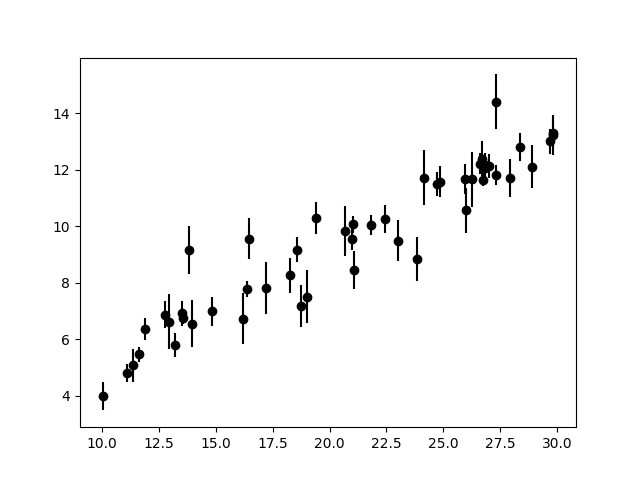

In [171]:
x_min = 10.0
x_max = 30.0
a_true = 0.4
b_true = 1.1
n_points = 50
min_noise = 0.2
max_noise = 1.0

x_obs = np.random.uniform(x_min, x_max, size=n_points)
y_err = np.ones(n_points) * noise_level
y_err = np.random.uniform(min_noise, max_noise, size=n_points)
y_obs = a_true * x_obs + b_true + np.random.normal(scale=y_err)

plt.figure()
plt.errorbar(x_obs, y_obs, yerr=y_err, fmt="ko")
plt.show()

#### The posterior

Assuming Gaussian uncertainties, the logarithm of the likelihood takes the usual $\chi^2$ form...

$$P(\left\{x_i, y_i\right\} | a, b) = -\sum\limits_{i} \frac{\left(y_i - a x_i - b\right)^2}{2\sigma_i^2} $$

The prior on $a$ and $b$ will be uniform but will constain their values in the permitted range $\left[0, 30\right]$.

Nothing new about the posterior: it is the product of the two (or sum in log-space).

In [172]:
def my_prior(theta):
    a, b = theta
    if a < 0.0 or a > 10.0 or b < 0.0 or b > 10.0:
        return -np.inf
    return 0.0

def my_likelihood(theta):
    a, b = theta
    return -np.sum((y_obs - a * x_obs - b) ** 2.0 / (2 * y_err ** 2.0))

def my_posterior(theta):
    return my_prior(theta) + my_likelihood(theta)

In [173]:
import emcee

n_walkers = 100
n_dim = 2
n_steps = 500

a0 = np.random.uniform(0.0, 3.0, size=n_walkers)
b0 = np.random.uniform(0.0, 3.0, size=n_walkers)

#p0 = np.array([a0, b0])  # make a column
p0 = np.array([a0, b0]).T

sampler = emcee.EnsembleSampler(nwalkers=n_walkers, dim=n_dim, lnpostfn=my_posterior)

In [174]:
result = sampler.run_mcmc(p0, N=n_steps)

In [175]:
print(sampler.chain.shape)

(100, 500, 2)


<IPython.core.display.Javascript object>


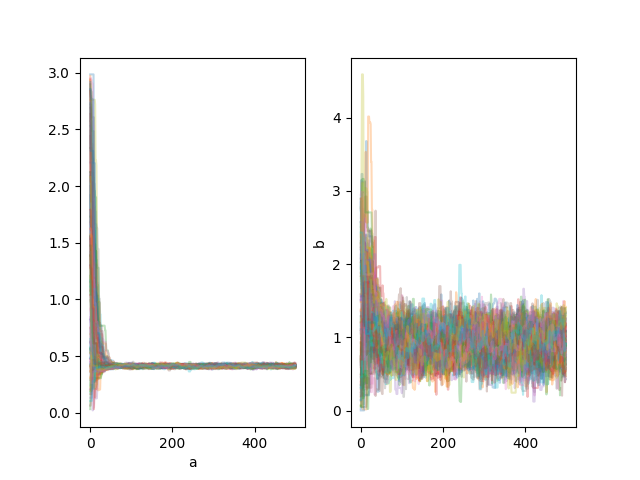

In [176]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_xlabel("a")
ax2.set_ylabel("b")

for i in range(n_walkers):
    chain = sampler.chain[i, :, :]
    a = chain[:, 0]
    ax1.plot(a, alpha=0.3)
    b = chain[:, 1]
    ax2.plot(b, alpha=0.3)
plt.show()

<IPython.core.display.Javascript object>


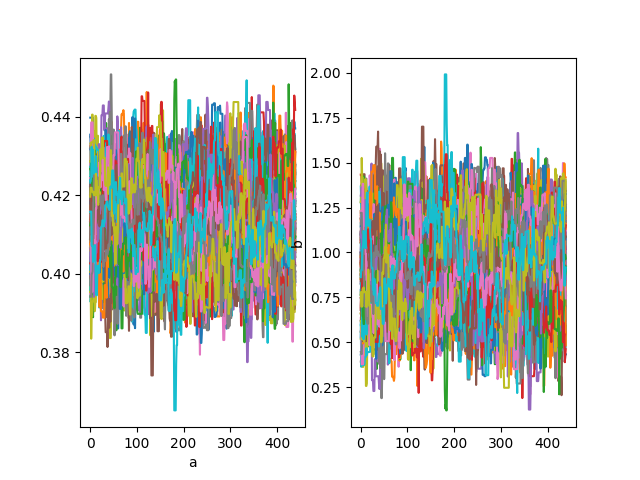

In [177]:
n_burnin = 60

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_xlabel("a")
ax2.set_ylabel("b")

for i in range(n_walkers):
    chain = sampler.chain[i, n_burnin:, :]
    a = chain[:, 0]
    ax1.plot(a)
    b = chain[:, 1]
    ax2.plot(b)
plt.show()

Shape of chain     : (100, 500, 2)
Shape of flatchain : (50000, 2)


<IPython.core.display.Javascript object>


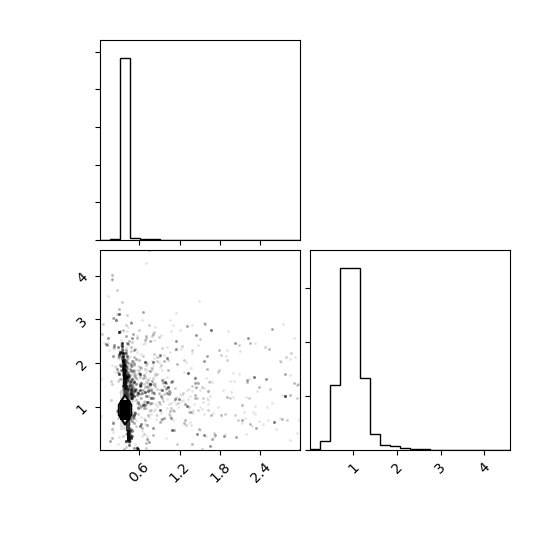

In [178]:
import corner
print("Shape of chain     :", sampler.chain.shape)
print("Shape of flatchain :", sampler.flatchain.shape)
fig = corner.corner(sampler.flatchain)

Converged chain shape     : (100, 440, 2)
Converged flatchain shape : (44000, 2)


<IPython.core.display.Javascript object>


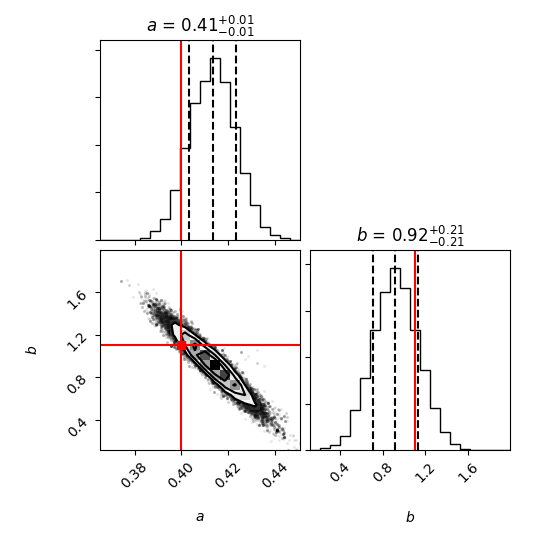

In [179]:
converged_chain = sampler.chain[:, n_burnin:, :]
print("Converged chain shape     :", converged_chain.shape)

flat_converged_chain = converged_chain.reshape(converged_chain.shape[0] * converged_chain.shape[1], -1)
print("Converged flatchain shape :", flat_converged_chain.shape)

fig = corner.corner(flat_converged_chain,
                    quantiles=[0.16, 0.5, 0.84],
                    truths=[a_true, b_true],
                    truth_color="r",
                    labels=[r"$a$", r"$b$"],
                    show_titles=True
                   )

### References

[1] Wikipedia contributors. (2019, May 9). Test functions for optimization. In Wikipedia, The Free Encyclopedia. Retrieved 20:20, June 12, 2019, from https://en.wikipedia.org/w/index.php?title=Test_functions_for_optimization&oldid=896257708

[2] Lee, Jaewook & Sung, Woosuk & Choi, Joo-Ho. (2015). Metamodel for Efficient Estimation of Capacity-Fade Uncertainty in Li-Ion Batteries for Electric Vehicles. Energies. 8. 5538-5554. 10.3390/en8065538.

[3] Foreman-Mackey, D., Hogg, D. W., Lang, D., & Goodman, J. 2013, PASP, 125, 306